In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
flipkarts = []

def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

def get_reviews(soup):
    flipkarts_a = []
    containers = soup.findAll("div", {'class': '_2wrUUKlw _3hFEdNs8'})
    for i in containers:
        ratings = i.select_one('span.ui_bubble_rating')['class']
        ratings = ratings[1].split('_')[-1]
        #print(ratings)
        re = {
        'rating' : ratings,
        'review' : i.find("q", {"class": "IRsGHoPm"}).text,
        }
        flipkarts_a.append(re)
    return flipkarts_a

for x in range(1,660,5):
    url = 'https://www.tripadvisor.in/Hotel_Review-g297628-d301774-Reviews-or'+str(x)+'-ITC_Windsor_Bengaluru_a_Luxury_Collection_Hotel-Bengaluru_Bangalore_District_Kar.html#REVIEWS'
    soup = get_soup(url)
    #print(f'Getting page: {x}')
    
    flipkarts = flipkarts + get_reviews(soup)
   # print(len(flipkarts))
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break
df = pd.DataFrame(flipkarts)
print(df.shape)
df.head()

(660, 2)


,rating,review
0,50,"We had visited ITC Windsor, Bangalore in end J..."
1,50,My recent stay at ITC Windsor was absolutely a...
2,30,Staycation is the much talked about vacation i...
3,50,Our whole family enjoy ur luxury rooms and won...
4,50,Great Job with the conference in all the arran...


In [6]:
df.groupby('rating').count()

,review
rating,
10,8
20,1
30,4
40,14
50,633


In [4]:
df.to_csv('itc.csv')

In [10]:
with open('itc.csv',encoding='utf-8') as f:
    bb_df = pd.read_csv(f)
f.close()
bb_df.drop('Unnamed: 0', axis=1, inplace=True)
bb_df

,rating,review
0,50,"We had visited ITC Windsor, Bangalore in end J..."
1,50,My recent stay at ITC Windsor was absolutely a...
2,30,Staycation is the much talked about vacation i...
3,50,Our whole family enjoy ur luxury rooms and won...
4,50,Great Job with the conference in all the arran...
...,...,...
655,50,I visited itc to have lunch with my friend the...
656,50,Best spotted place in bangalore to stay and th...
657,50,"Very accommodating staff and fast services , I..."
658,50,"ITC Windsor , Bangalore is one of the most pre..."


In [146]:
#bb_df['review'] = bb_df['review'].str.replace('READ MORE', '')
#bb_df['review'] = bb_df['review'].str.replace('phone', '')
#bb_df['review'] = bb_df['review'].str.replace('good', '')
#bb_df['review'] = bb_df['review'].str.replace('...', '')

#bb_df

,rating,review
0,1,The network is not doing a job. Where other s...
1,1,The body is very delicate.. it got scratches a...
2,1,WASTE OF MONEY. 1st thing is the charge. it ha...
3,1,After use more then 6 days i write this review...
4,1,If you are camera lover the don't wst your mo...
...,...,...
4923,4,Ok camera is not expected quality overall
4924,4,It is very and its worth buying
4925,4,"dude.....video doesn't support 1080 at 60fps,j..."
4926,4,Good .. slightly higher price


In [11]:
#tokenizing the reviews
bb_df['tokenized'] = bb_df['review'].apply(word_tokenize)
#converting all to lowercase
bb_df['lower'] = bb_df['tokenized'].apply(lambda x: [word.lower() for word in x])
#removing punctuations
punc = string.punctuation
bb_df['no_punc'] = bb_df['lower'].apply(lambda x: [word for word in x if word not in punc])
#removing stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['.',';'])
bb_df['stopwords_removed'] = bb_df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed
0,50,"We had visited ITC Windsor, Bangalore in end J...","[We, had, visited, ITC, Windsor, ,, Bangalore,...","[we, had, visited, itc, windsor, ,, bangalore,...","[we, had, visited, itc, windsor, bangalore, in...","[visited, itc, windsor, bangalore, end, jan, 2..."
1,50,My recent stay at ITC Windsor was absolutely a...,"[My, recent, stay, at, ITC, Windsor, was, abso...","[my, recent, stay, at, itc, windsor, was, abso...","[my, recent, stay, at, itc, windsor, was, abso...","[recent, stay, itc, windsor, absolutely, amazi..."
2,30,Staycation is the much talked about vacation i...,"[Staycation, is, the, much, talked, about, vac...","[staycation, is, the, much, talked, about, vac...","[staycation, is, the, much, talked, about, vac...","[staycation, much, talked, vacation, times, ex..."
3,50,Our whole family enjoy ur luxury rooms and won...,"[Our, whole, family, enjoy, ur, luxury, rooms,...","[our, whole, family, enjoy, ur, luxury, rooms,...","[our, whole, family, enjoy, ur, luxury, rooms,...","[whole, family, enjoy, ur, luxury, rooms, wond..."
4,50,Great Job with the conference in all the arran...,"[Great, Job, with, the, conference, in, all, t...","[great, job, with, the, conference, in, all, t...","[great, job, with, the, conference, in, all, t...","[great, job, conference, arrangements, satya, ..."


In [12]:
#lemmitization
#first apply parts of speech tags
bb_df['pos_tags'] = bb_df['stopwords_removed'].apply(nltk.tag.pos_tag)
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,50,"We had visited ITC Windsor, Bangalore in end J...","[We, had, visited, ITC, Windsor, ,, Bangalore,...","[we, had, visited, itc, windsor, ,, bangalore,...","[we, had, visited, itc, windsor, bangalore, in...","[visited, itc, windsor, bangalore, end, jan, 2...","[(visited, VBN), (itc, NN), (windsor, NN), (ba..."
1,50,My recent stay at ITC Windsor was absolutely a...,"[My, recent, stay, at, ITC, Windsor, was, abso...","[my, recent, stay, at, itc, windsor, was, abso...","[my, recent, stay, at, itc, windsor, was, abso...","[recent, stay, itc, windsor, absolutely, amazi...","[(recent, JJ), (stay, NN), (itc, RB), (windsor..."
2,30,Staycation is the much talked about vacation i...,"[Staycation, is, the, much, talked, about, vac...","[staycation, is, the, much, talked, about, vac...","[staycation, is, the, much, talked, about, vac...","[staycation, much, talked, vacation, times, ex...","[(staycation, NN), (much, RB), (talked, VBD), ..."
3,50,Our whole family enjoy ur luxury rooms and won...,"[Our, whole, family, enjoy, ur, luxury, rooms,...","[our, whole, family, enjoy, ur, luxury, rooms,...","[our, whole, family, enjoy, ur, luxury, rooms,...","[whole, family, enjoy, ur, luxury, rooms, wond...","[(whole, JJ), (family, NN), (enjoy, VB), (ur, ..."
4,50,Great Job with the conference in all the arran...,"[Great, Job, with, the, conference, in, all, t...","[great, job, with, the, conference, in, all, t...","[great, job, with, the, conference, in, all, t...","[great, job, conference, arrangements, satya, ...","[(great, JJ), (job, NN), (conference, NN), (ar..."


In [13]:
#lemmitizing only certain parts of speech using the custom function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
bb_df['wordnet_pos'] = bb_df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
bb_df['lemmatized'] = bb_df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,50,"We had visited ITC Windsor, Bangalore in end J...","[We, had, visited, ITC, Windsor, ,, Bangalore,...","[we, had, visited, itc, windsor, ,, bangalore,...","[we, had, visited, itc, windsor, bangalore, in...","[visited, itc, windsor, bangalore, end, jan, 2...","[(visited, VBN), (itc, NN), (windsor, NN), (ba...","[(visited, v), (itc, n), (windsor, n), (bangal...","[visit, itc, windsor, bangalore, end, jan, 202..."
1,50,My recent stay at ITC Windsor was absolutely a...,"[My, recent, stay, at, ITC, Windsor, was, abso...","[my, recent, stay, at, itc, windsor, was, abso...","[my, recent, stay, at, itc, windsor, was, abso...","[recent, stay, itc, windsor, absolutely, amazi...","[(recent, JJ), (stay, NN), (itc, RB), (windsor...","[(recent, a), (stay, n), (itc, r), (windsor, v...","[recent, stay, itc, windsor, absolutely, amazi..."
2,30,Staycation is the much talked about vacation i...,"[Staycation, is, the, much, talked, about, vac...","[staycation, is, the, much, talked, about, vac...","[staycation, is, the, much, talked, about, vac...","[staycation, much, talked, vacation, times, ex...","[(staycation, NN), (much, RB), (talked, VBD), ...","[(staycation, n), (much, r), (talked, v), (vac...","[staycation, much, talk, vacation, time, explo..."
3,50,Our whole family enjoy ur luxury rooms and won...,"[Our, whole, family, enjoy, ur, luxury, rooms,...","[our, whole, family, enjoy, ur, luxury, rooms,...","[our, whole, family, enjoy, ur, luxury, rooms,...","[whole, family, enjoy, ur, luxury, rooms, wond...","[(whole, JJ), (family, NN), (enjoy, VB), (ur, ...","[(whole, a), (family, n), (enjoy, v), (ur, a),...","[whole, family, enjoy, ur, luxury, room, wonde..."
4,50,Great Job with the conference in all the arran...,"[Great, Job, with, the, conference, in, all, t...","[great, job, with, the, conference, in, all, t...","[great, job, with, the, conference, in, all, t...","[great, job, conference, arrangements, satya, ...","[(great, JJ), (job, NN), (conference, NN), (ar...","[(great, a), (job, n), (conference, n), (arran...","[great, job, conference, arrangement, satya, j..."


****Sentiment analysis using text blob****

In [14]:
bb_df_new = bb_df[['rating','lemmatized']]
#forming a string in order to determine the sentiment of review using textblob
bb_df_new['lemma_str'] = [' '.join(map(str,l)) for l in bb_df_new['lemmatized']]
bb_df_new

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,rating,lemmatized,lemma_str
0,50,"[visit, itc, windsor, bangalore, end, jan, 202...",visit itc windsor bangalore end jan 2021 decid...
1,50,"[recent, stay, itc, windsor, absolutely, amazi...",recent stay itc windsor absolutely amazing rig...
2,30,"[staycation, much, talk, vacation, time, explo...",staycation much talk vacation time explore ban...
3,50,"[whole, family, enjoy, ur, luxury, room, wonde...",whole family enjoy ur luxury room wonderful ta...
4,50,"[great, job, conference, arrangement, satya, j...",great job conference arrangement satya jayaram...
...,...,...,...
655,50,"[visit, itc, lunch, friend, food, really, fant...",visit itc lunch friend food really fantastic w...
656,50,"[best, spotted, place, bangalore, stay, dublin...",best spotted place bangalore stay dublin famou...
657,50,"[accommodate, staff, fast, service, reason, lo...",accommodate staff fast service reason love hot...
658,50,"[itc, windsor, bangalore, one, premium, hotel,...",itc windsor bangalore one premium hotel city s...


In [15]:
bb_df_new['sentiment'] = bb_df_new['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
bb_df_new.head()

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,rating,lemmatized,lemma_str,sentiment
0,50,"[visit, itc, windsor, bangalore, end, jan, 202...",visit itc windsor bangalore end jan 2021 decid...,0.502296
1,50,"[recent, stay, itc, windsor, absolutely, amazi...",recent stay itc windsor absolutely amazing rig...,0.426374
2,30,"[staycation, much, talk, vacation, time, explo...",staycation much talk vacation time explore ban...,0.158532
3,50,"[whole, family, enjoy, ur, luxury, room, wonde...",whole family enjoy ur luxury room wonderful ta...,0.480000
4,50,"[great, job, conference, arrangement, satya, j...",great job conference arrangement satya jayaram...,0.475000


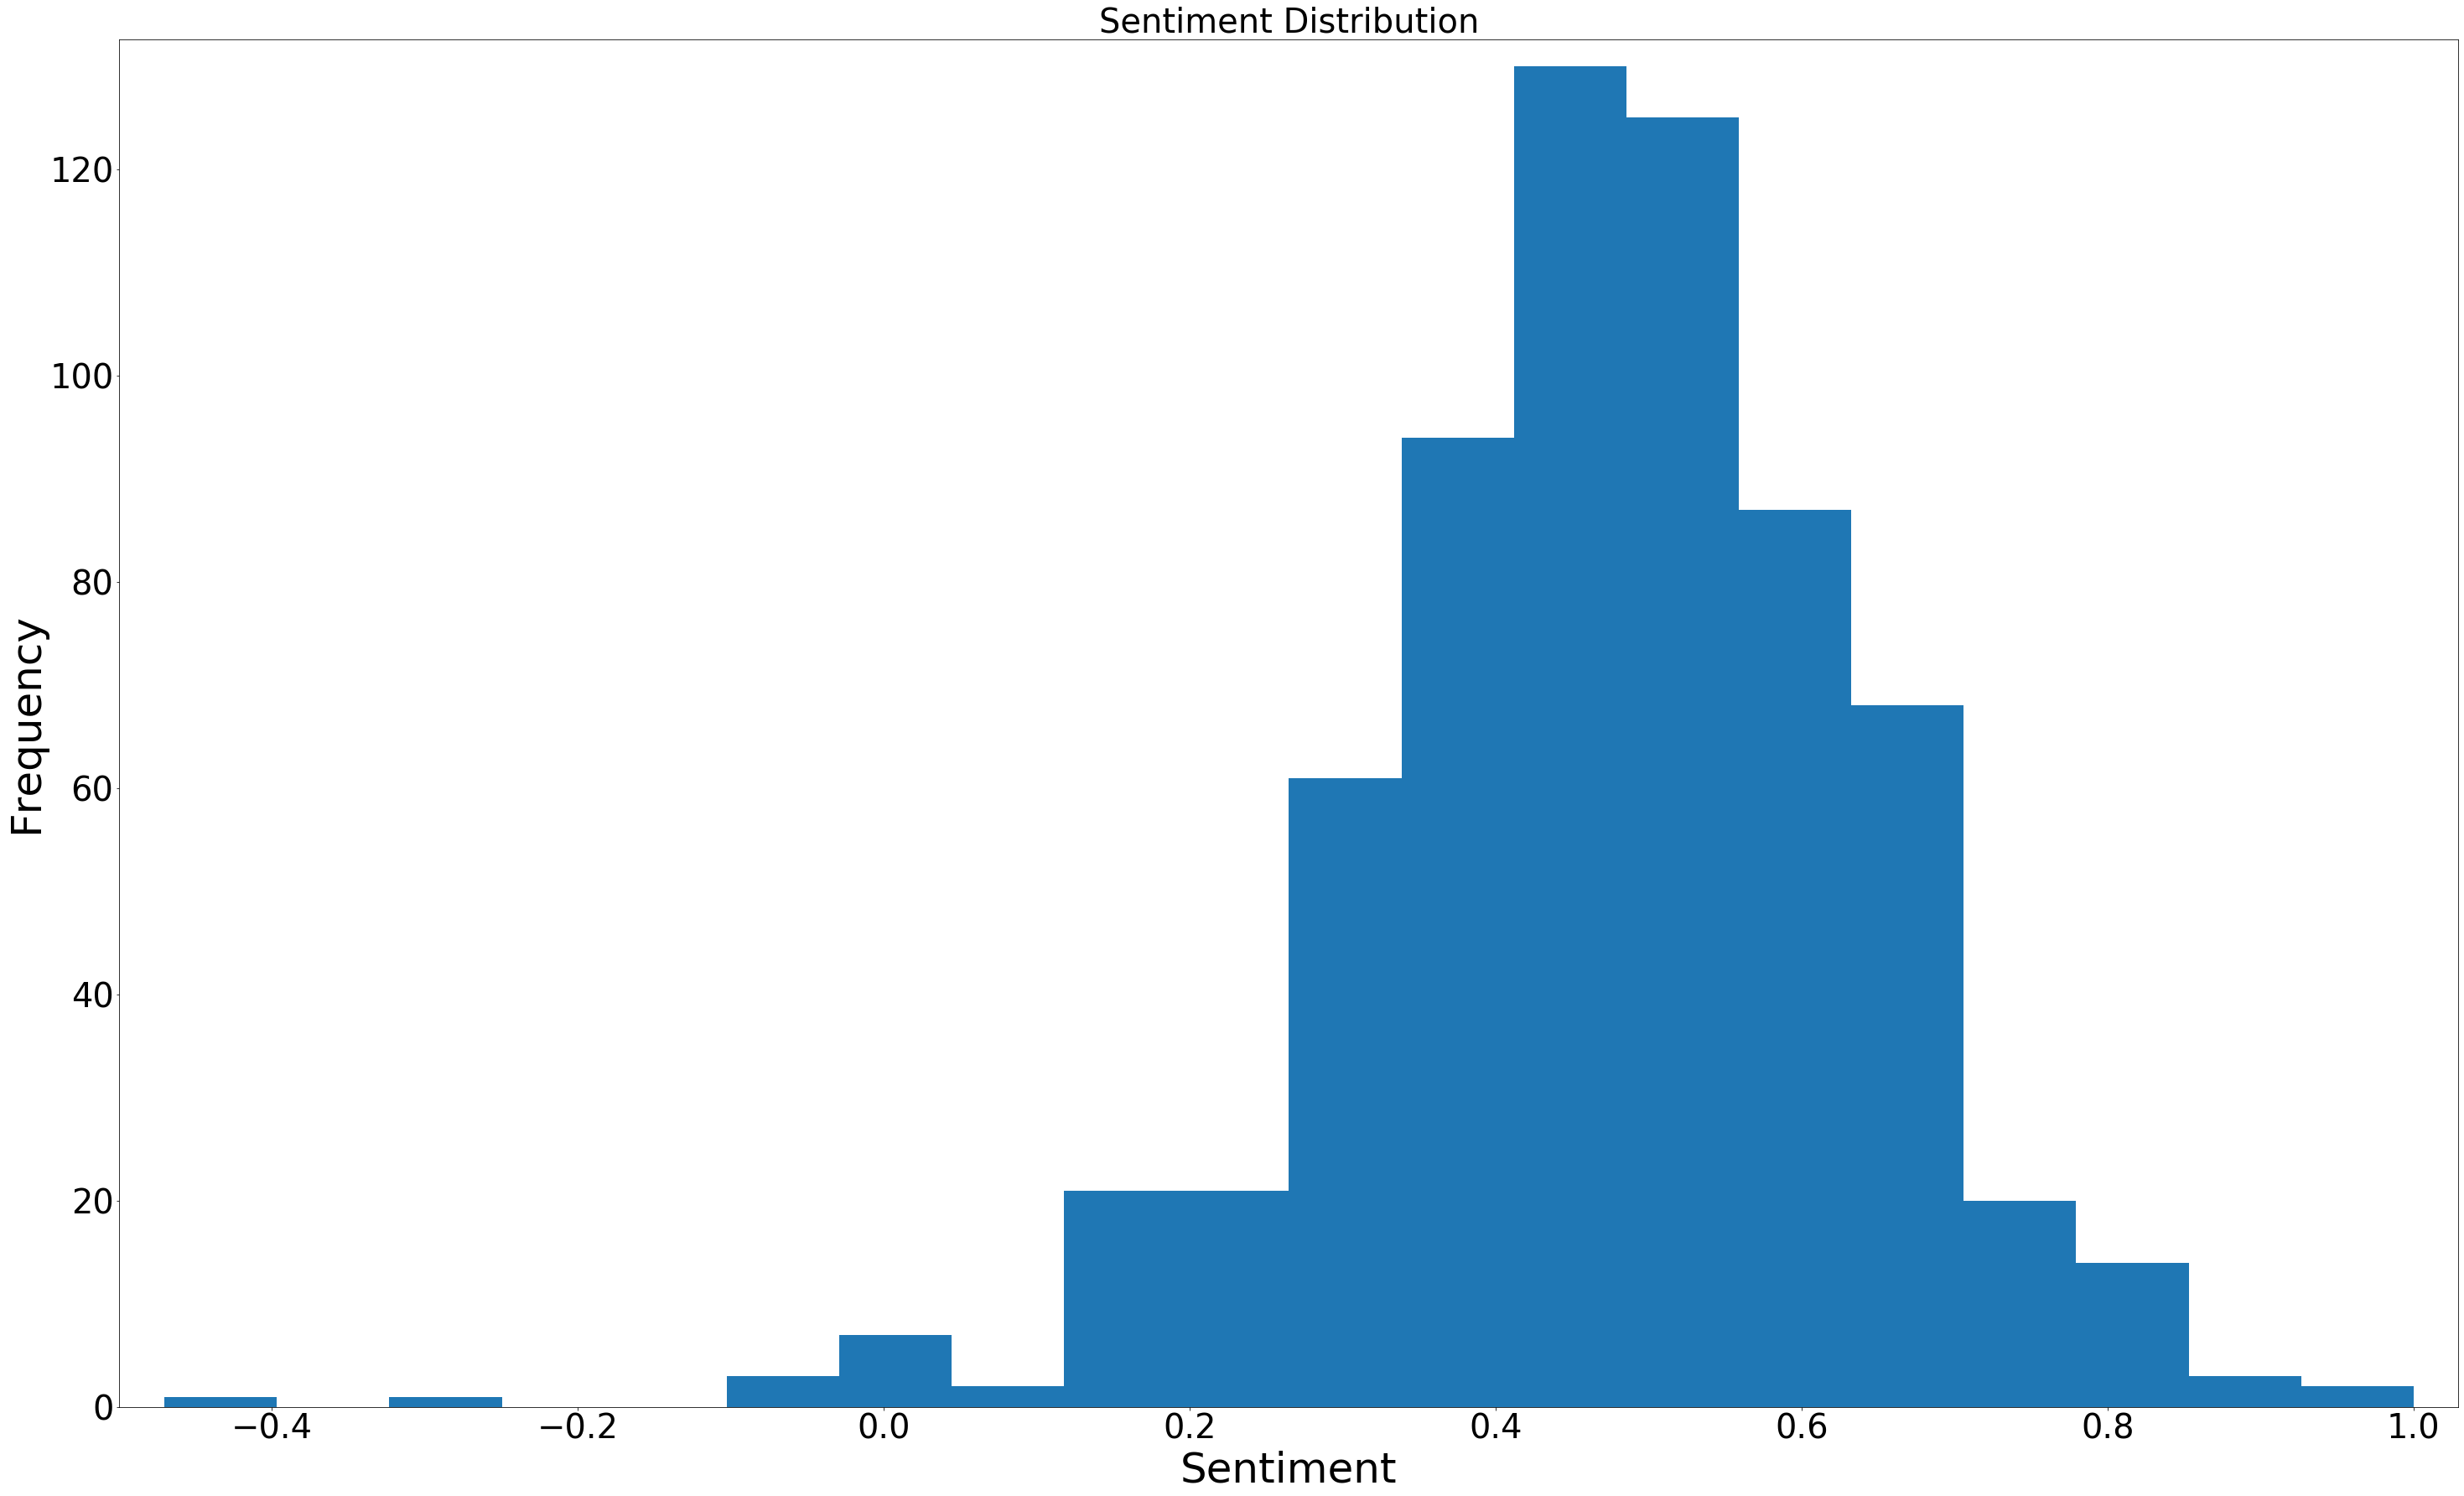

In [16]:
#sentiment distribution
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(bb_df_new['sentiment'], bins=20)
plt.title('Sentiment Distribution', fontsize=40)
plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

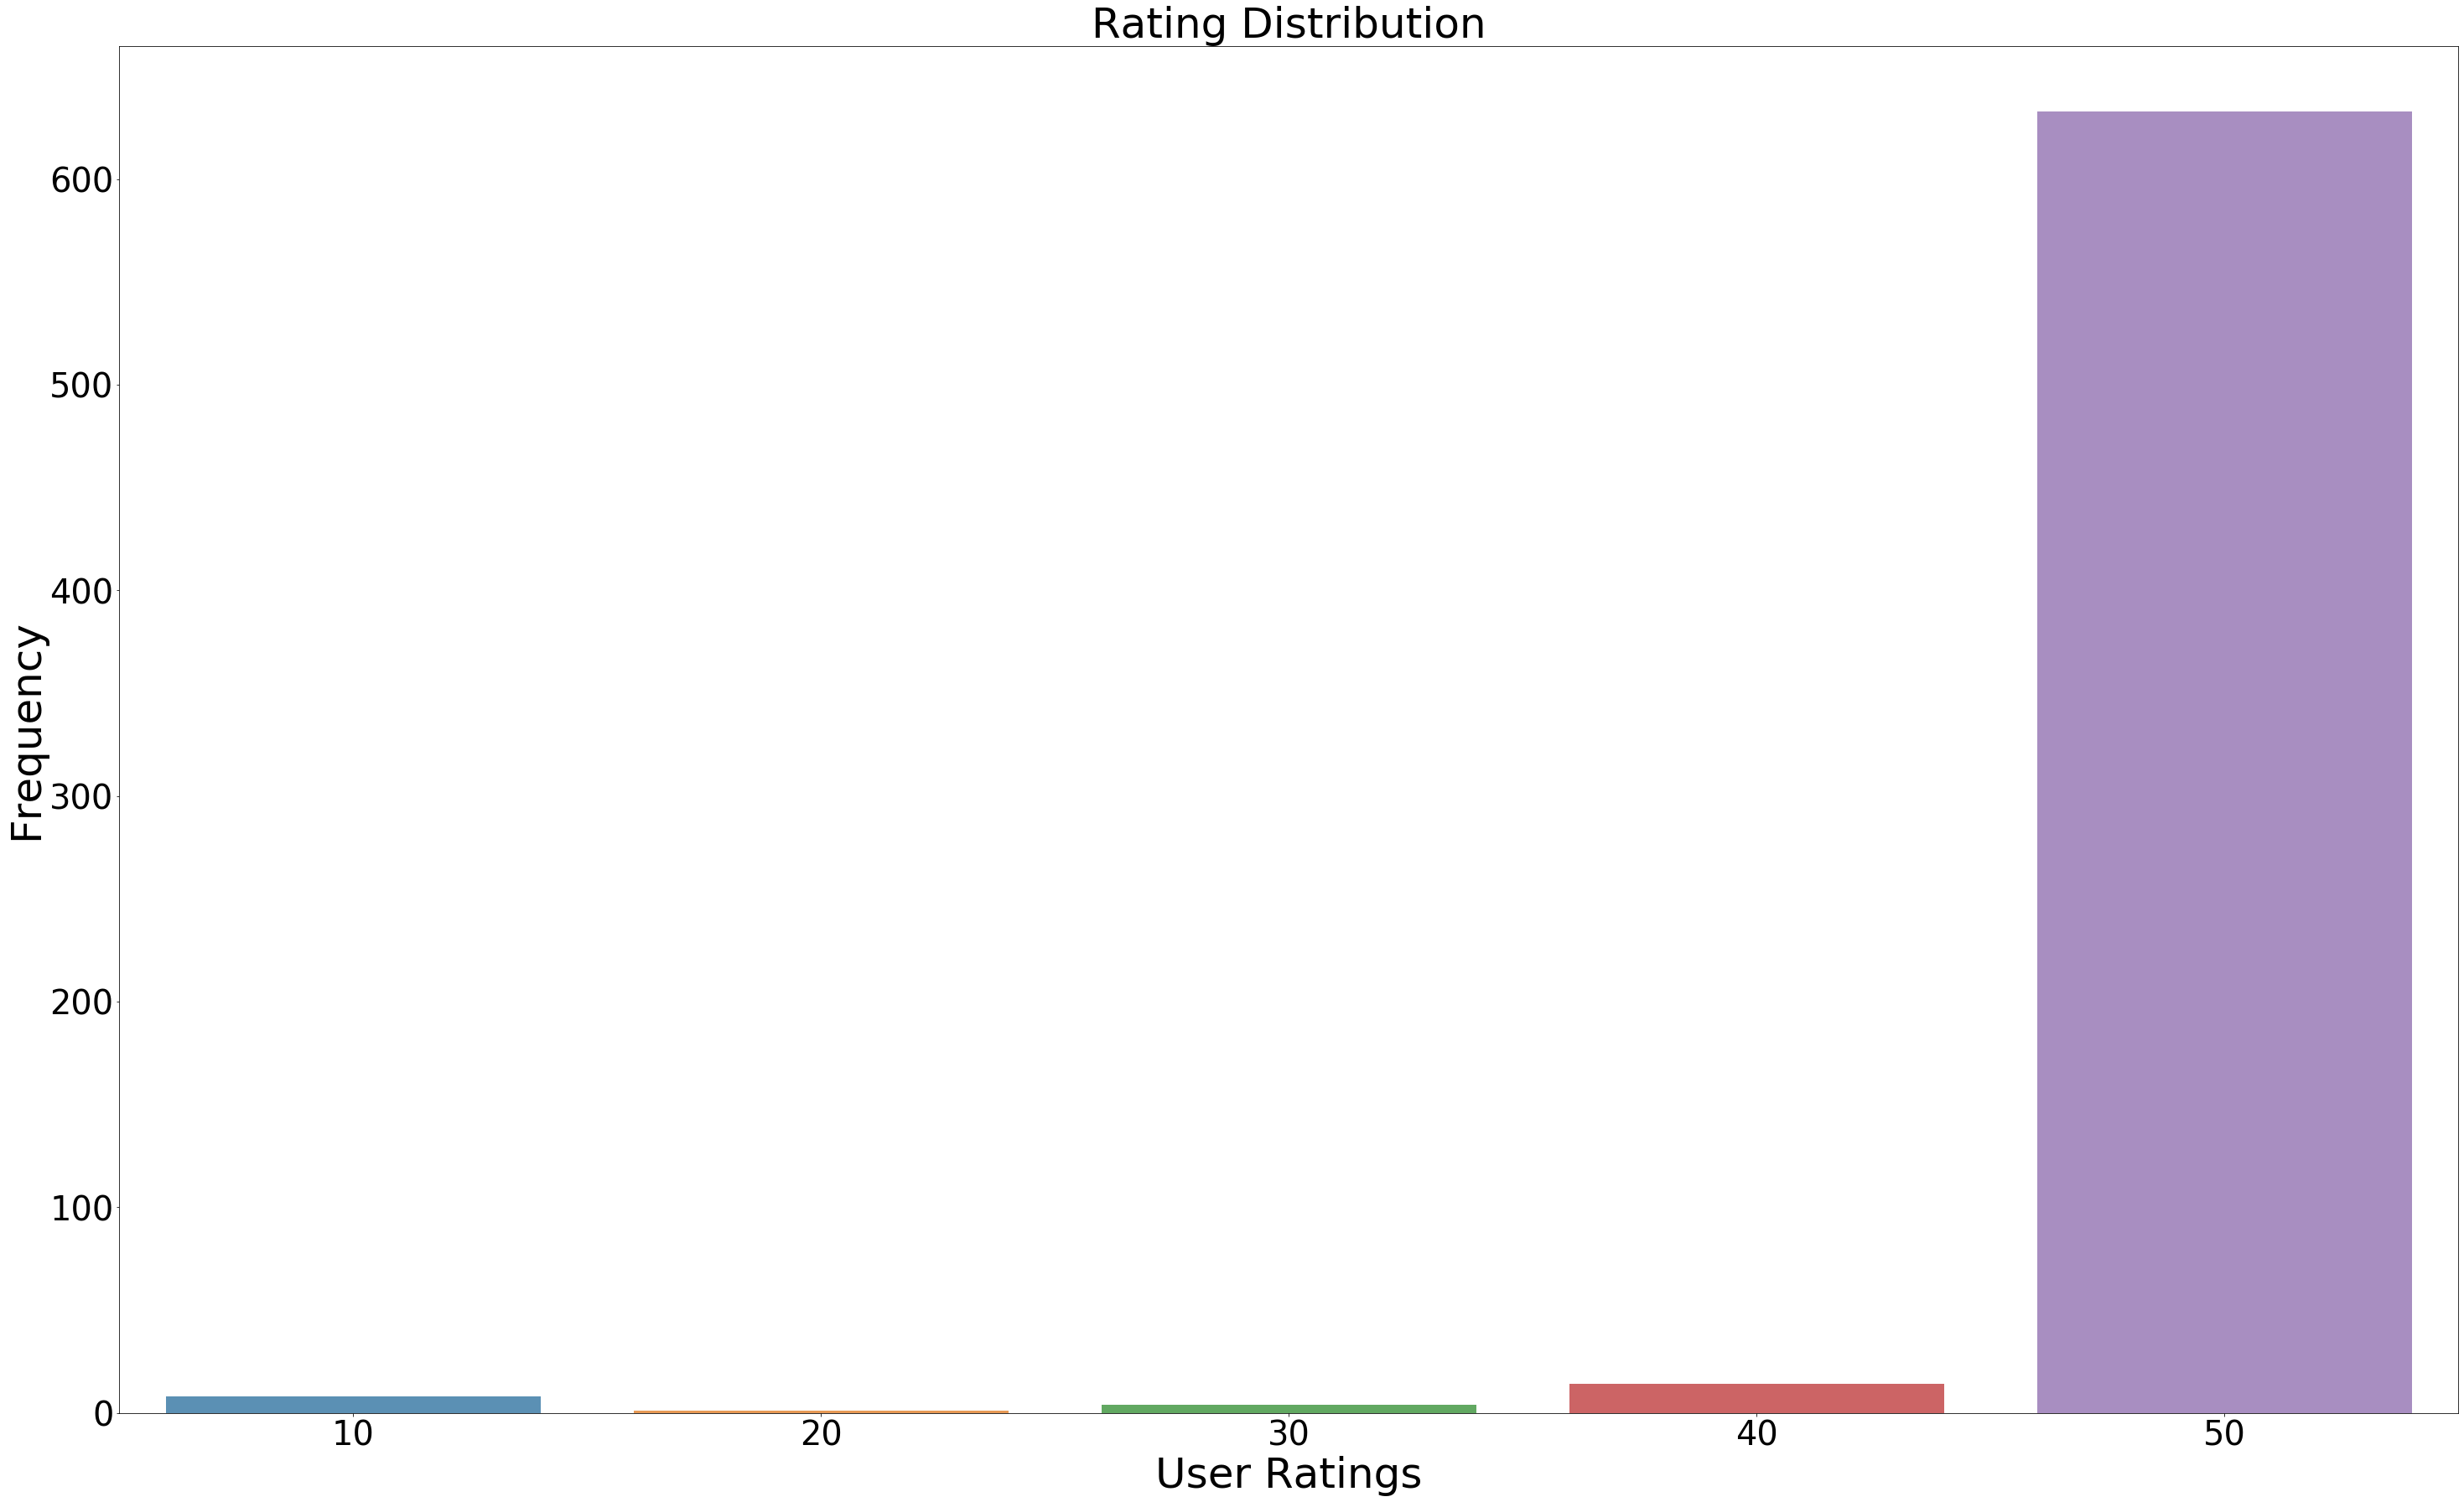

In [17]:
#rating distribution
x_rating = bb_df_new.rating.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('User Ratings', fontsize=50)
plt.xticks(fontsize=40)

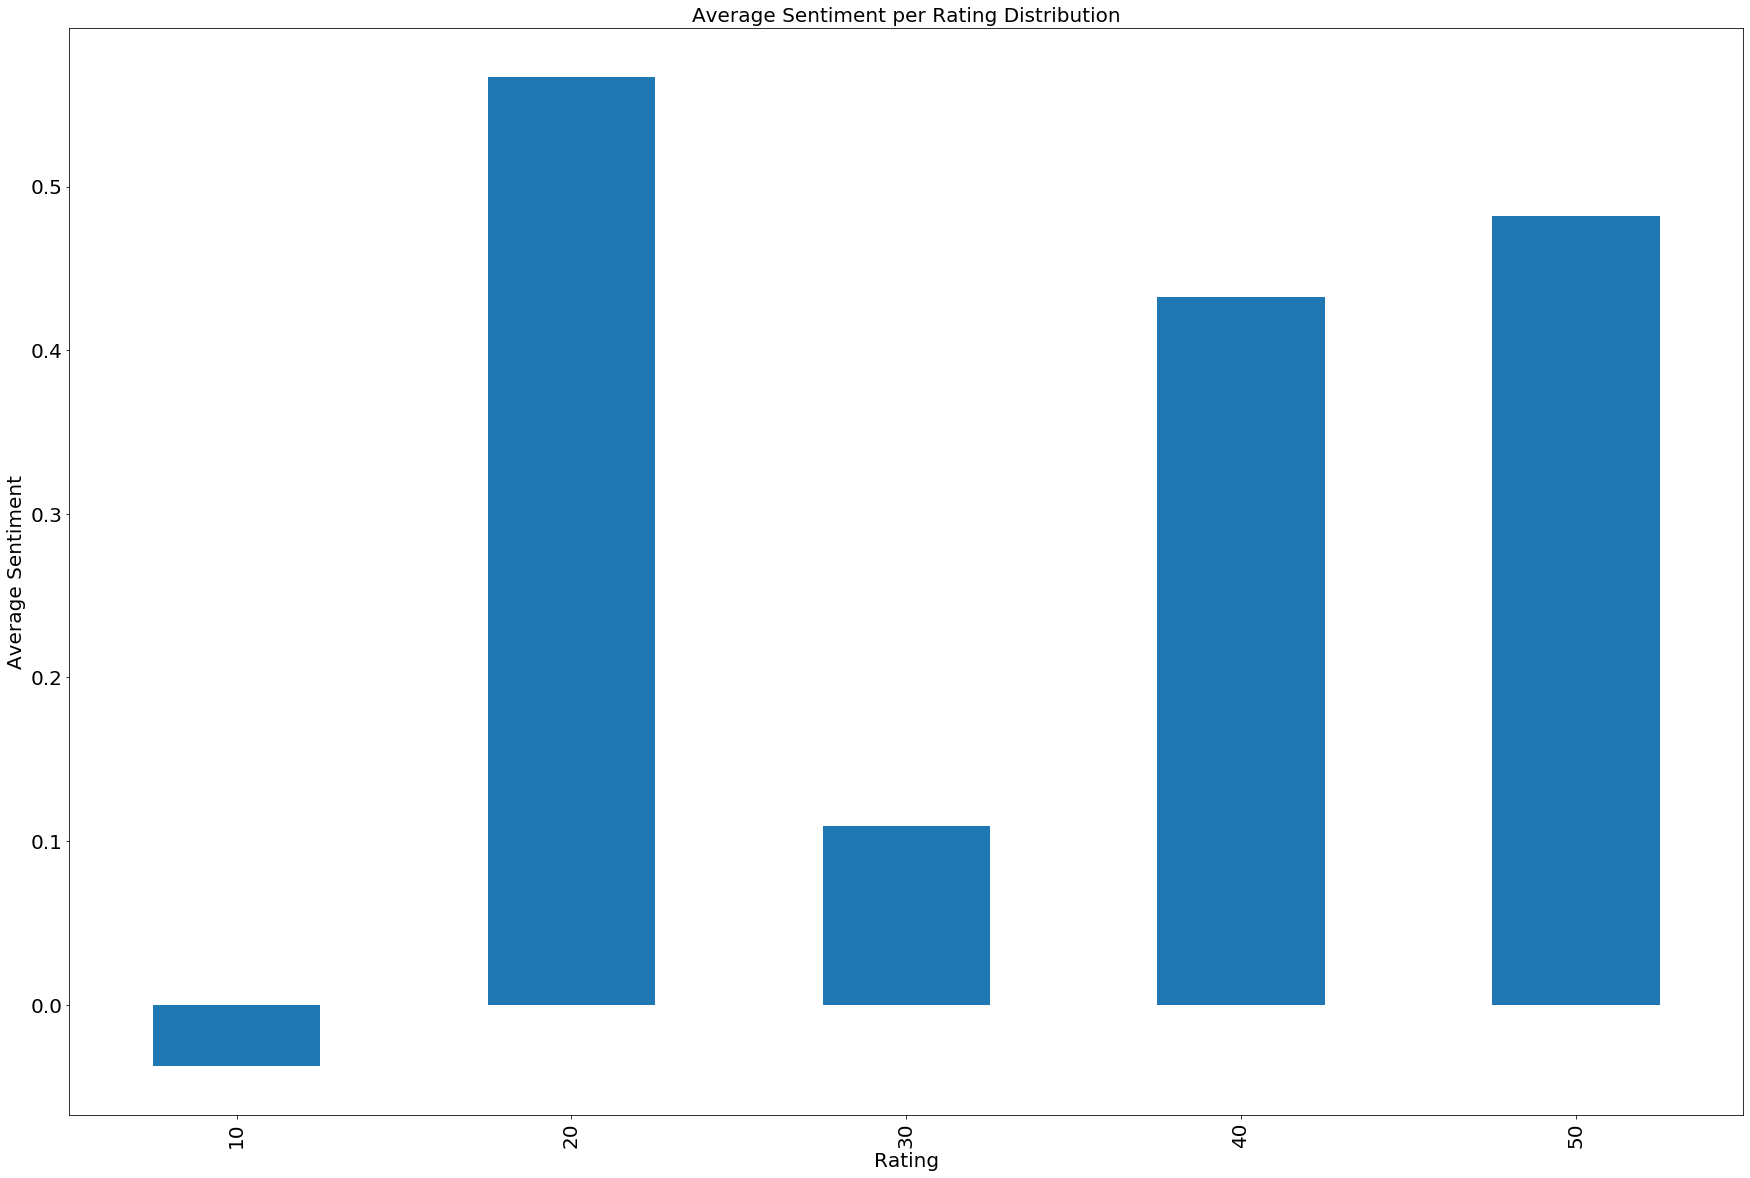

In [18]:
#sentiment and rating distribution
polarity_avg = bb_df_new.groupby('rating')['sentiment'].mean().plot(kind='bar', figsize=(30,20))
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Average Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Sentiment per Rating Distribution', fontsize=20)
plt.show()

In [19]:
review_type = []
for i in bb_df_new['rating']:
    if i == 10:
        t = 'Negative'
    elif i == 20:
        t = 'Negative'
    elif i == 30:
        t = 'Negative'
    else:
        t = 'Positive'
    
    review_type.append(t)

In [20]:
bb_df_new['review_type'] = review_type
bb_df_new

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,rating,lemmatized,lemma_str,sentiment,review_type
0,50,"[visit, itc, windsor, bangalore, end, jan, 202...",visit itc windsor bangalore end jan 2021 decid...,0.502296,Positive
1,50,"[recent, stay, itc, windsor, absolutely, amazi...",recent stay itc windsor absolutely amazing rig...,0.426374,Positive
2,30,"[staycation, much, talk, vacation, time, explo...",staycation much talk vacation time explore ban...,0.158532,Negative
3,50,"[whole, family, enjoy, ur, luxury, room, wonde...",whole family enjoy ur luxury room wonderful ta...,0.480000,Positive
4,50,"[great, job, conference, arrangement, satya, j...",great job conference arrangement satya jayaram...,0.475000,Positive
...,...,...,...,...,...
655,50,"[visit, itc, lunch, friend, food, really, fant...",visit itc lunch friend food really fantastic w...,0.600000,Positive
656,50,"[best, spotted, place, bangalore, stay, dublin...",best spotted place bangalore stay dublin famou...,0.612500,Positive
657,50,"[accommodate, staff, fast, service, reason, lo...",accommodate staff fast service reason love hot...,0.420000,Positive
658,50,"[itc, windsor, bangalore, one, premium, hotel,...",itc windsor bangalore one premium hotel city s...,0.500000,Positive


In [21]:
bb_negative = bb_df_new[bb_df_new['review_type']=='Negative']
bb_positive = bb_df_new[bb_df_new['review_type']=='Positive']
bb_positive

,rating,lemmatized,lemma_str,sentiment,review_type
0,50,"[visit, itc, windsor, bangalore, end, jan, 202...",visit itc windsor bangalore end jan 2021 decid...,0.502296,Positive
1,50,"[recent, stay, itc, windsor, absolutely, amazi...",recent stay itc windsor absolutely amazing rig...,0.426374,Positive
3,50,"[whole, family, enjoy, ur, luxury, room, wonde...",whole family enjoy ur luxury room wonderful ta...,0.480000,Positive
4,50,"[great, job, conference, arrangement, satya, j...",great job conference arrangement satya jayaram...,0.475000,Positive
5,50,"[great, service, abhishek, reception, equally,...",great service abhishek reception equally good ...,0.733333,Positive
...,...,...,...,...,...
655,50,"[visit, itc, lunch, friend, food, really, fant...",visit itc lunch friend food really fantastic w...,0.600000,Positive
656,50,"[best, spotted, place, bangalore, stay, dublin...",best spotted place bangalore stay dublin famou...,0.612500,Positive
657,50,"[accommodate, staff, fast, service, reason, lo...",accommodate staff fast service reason love hot...,0.420000,Positive
658,50,"[itc, windsor, bangalore, one, premium, hotel,...",itc windsor bangalore one premium hotel city s...,0.500000,Positive


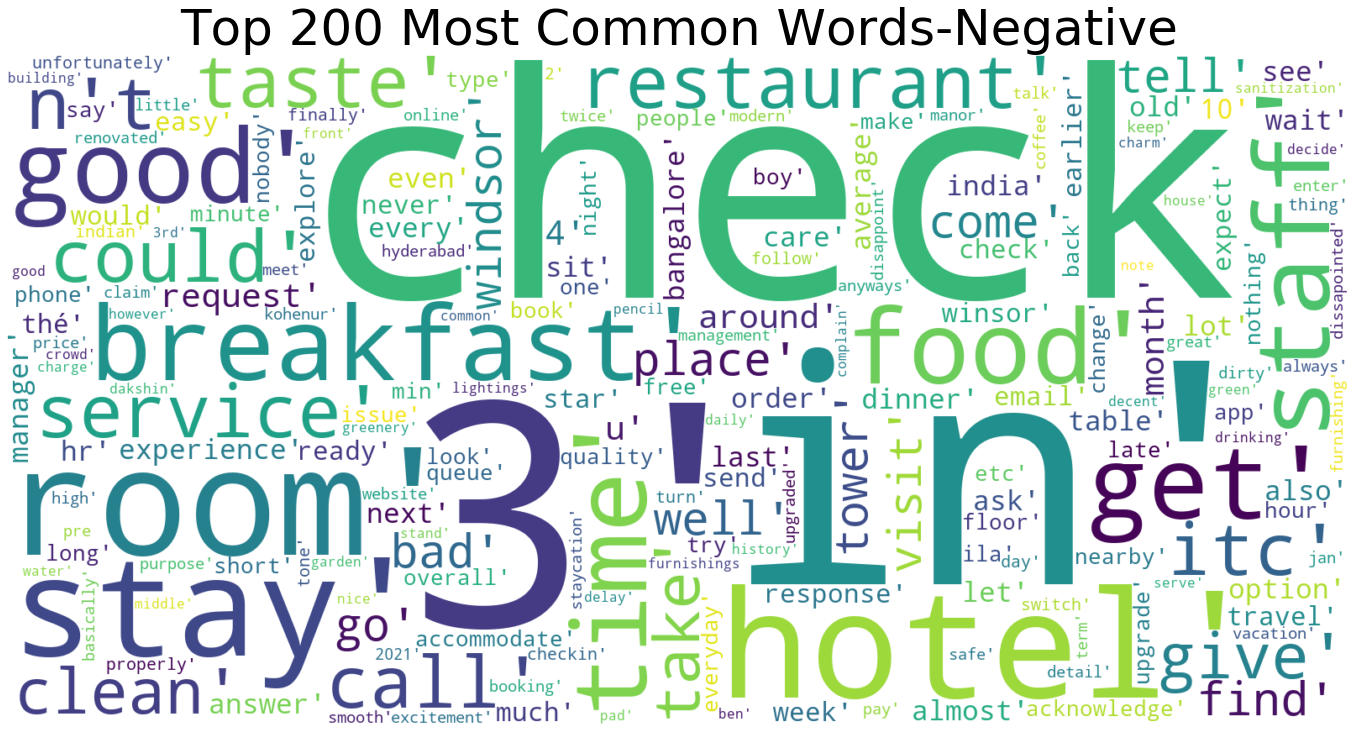

In [22]:
#word cloud for negative words

neg_words = bb_negative['lemmatized']
allwords_neg = []
for wordlist in neg_words:
    allwords_neg += wordlist
mostcommon_neg = FreqDist(allwords_neg).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_neg))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 200 Most Common Words-Negative', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

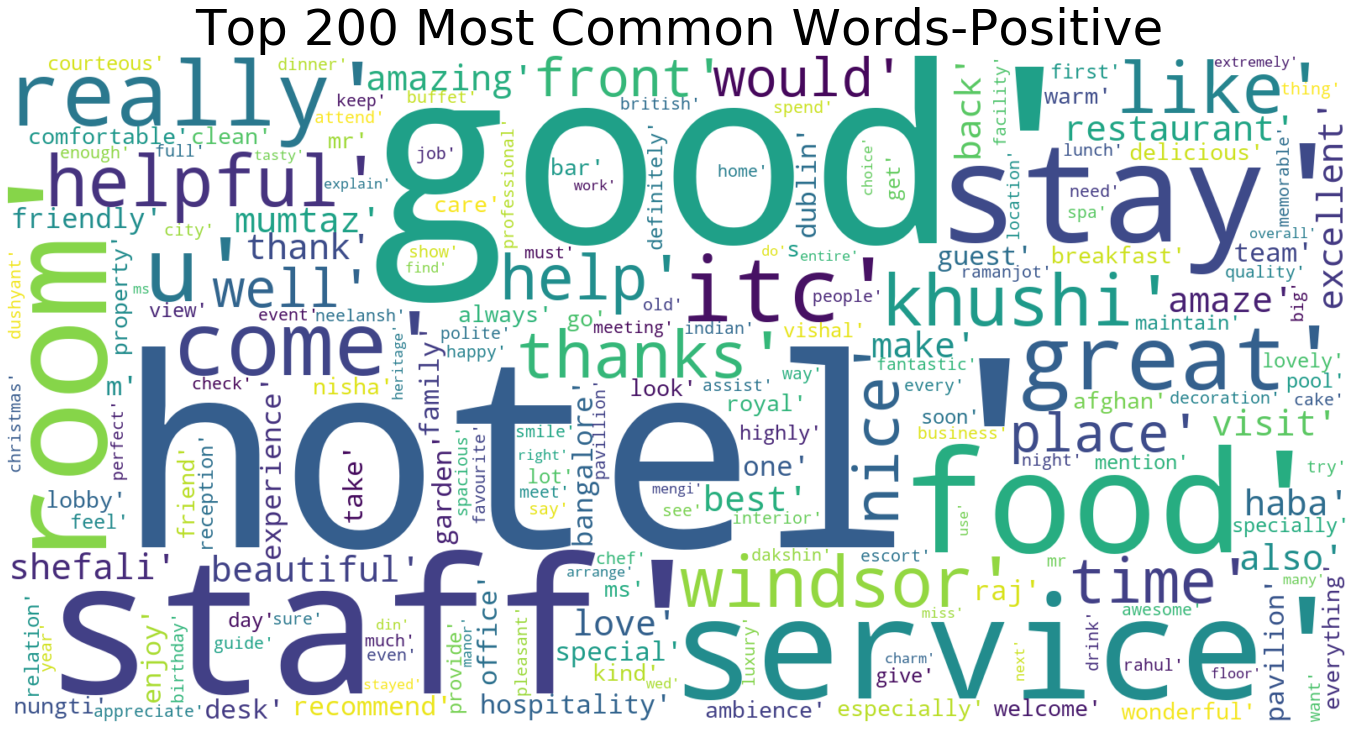

In [23]:
#word cloud for positive reviews

pos_words = bb_positive['lemmatized']
allwords_pos = []
for wordlist in pos_words:
    allwords_pos += wordlist
mostcommon_pos = FreqDist(allwords_pos).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_pos))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 200 Most Common Words-Positive', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

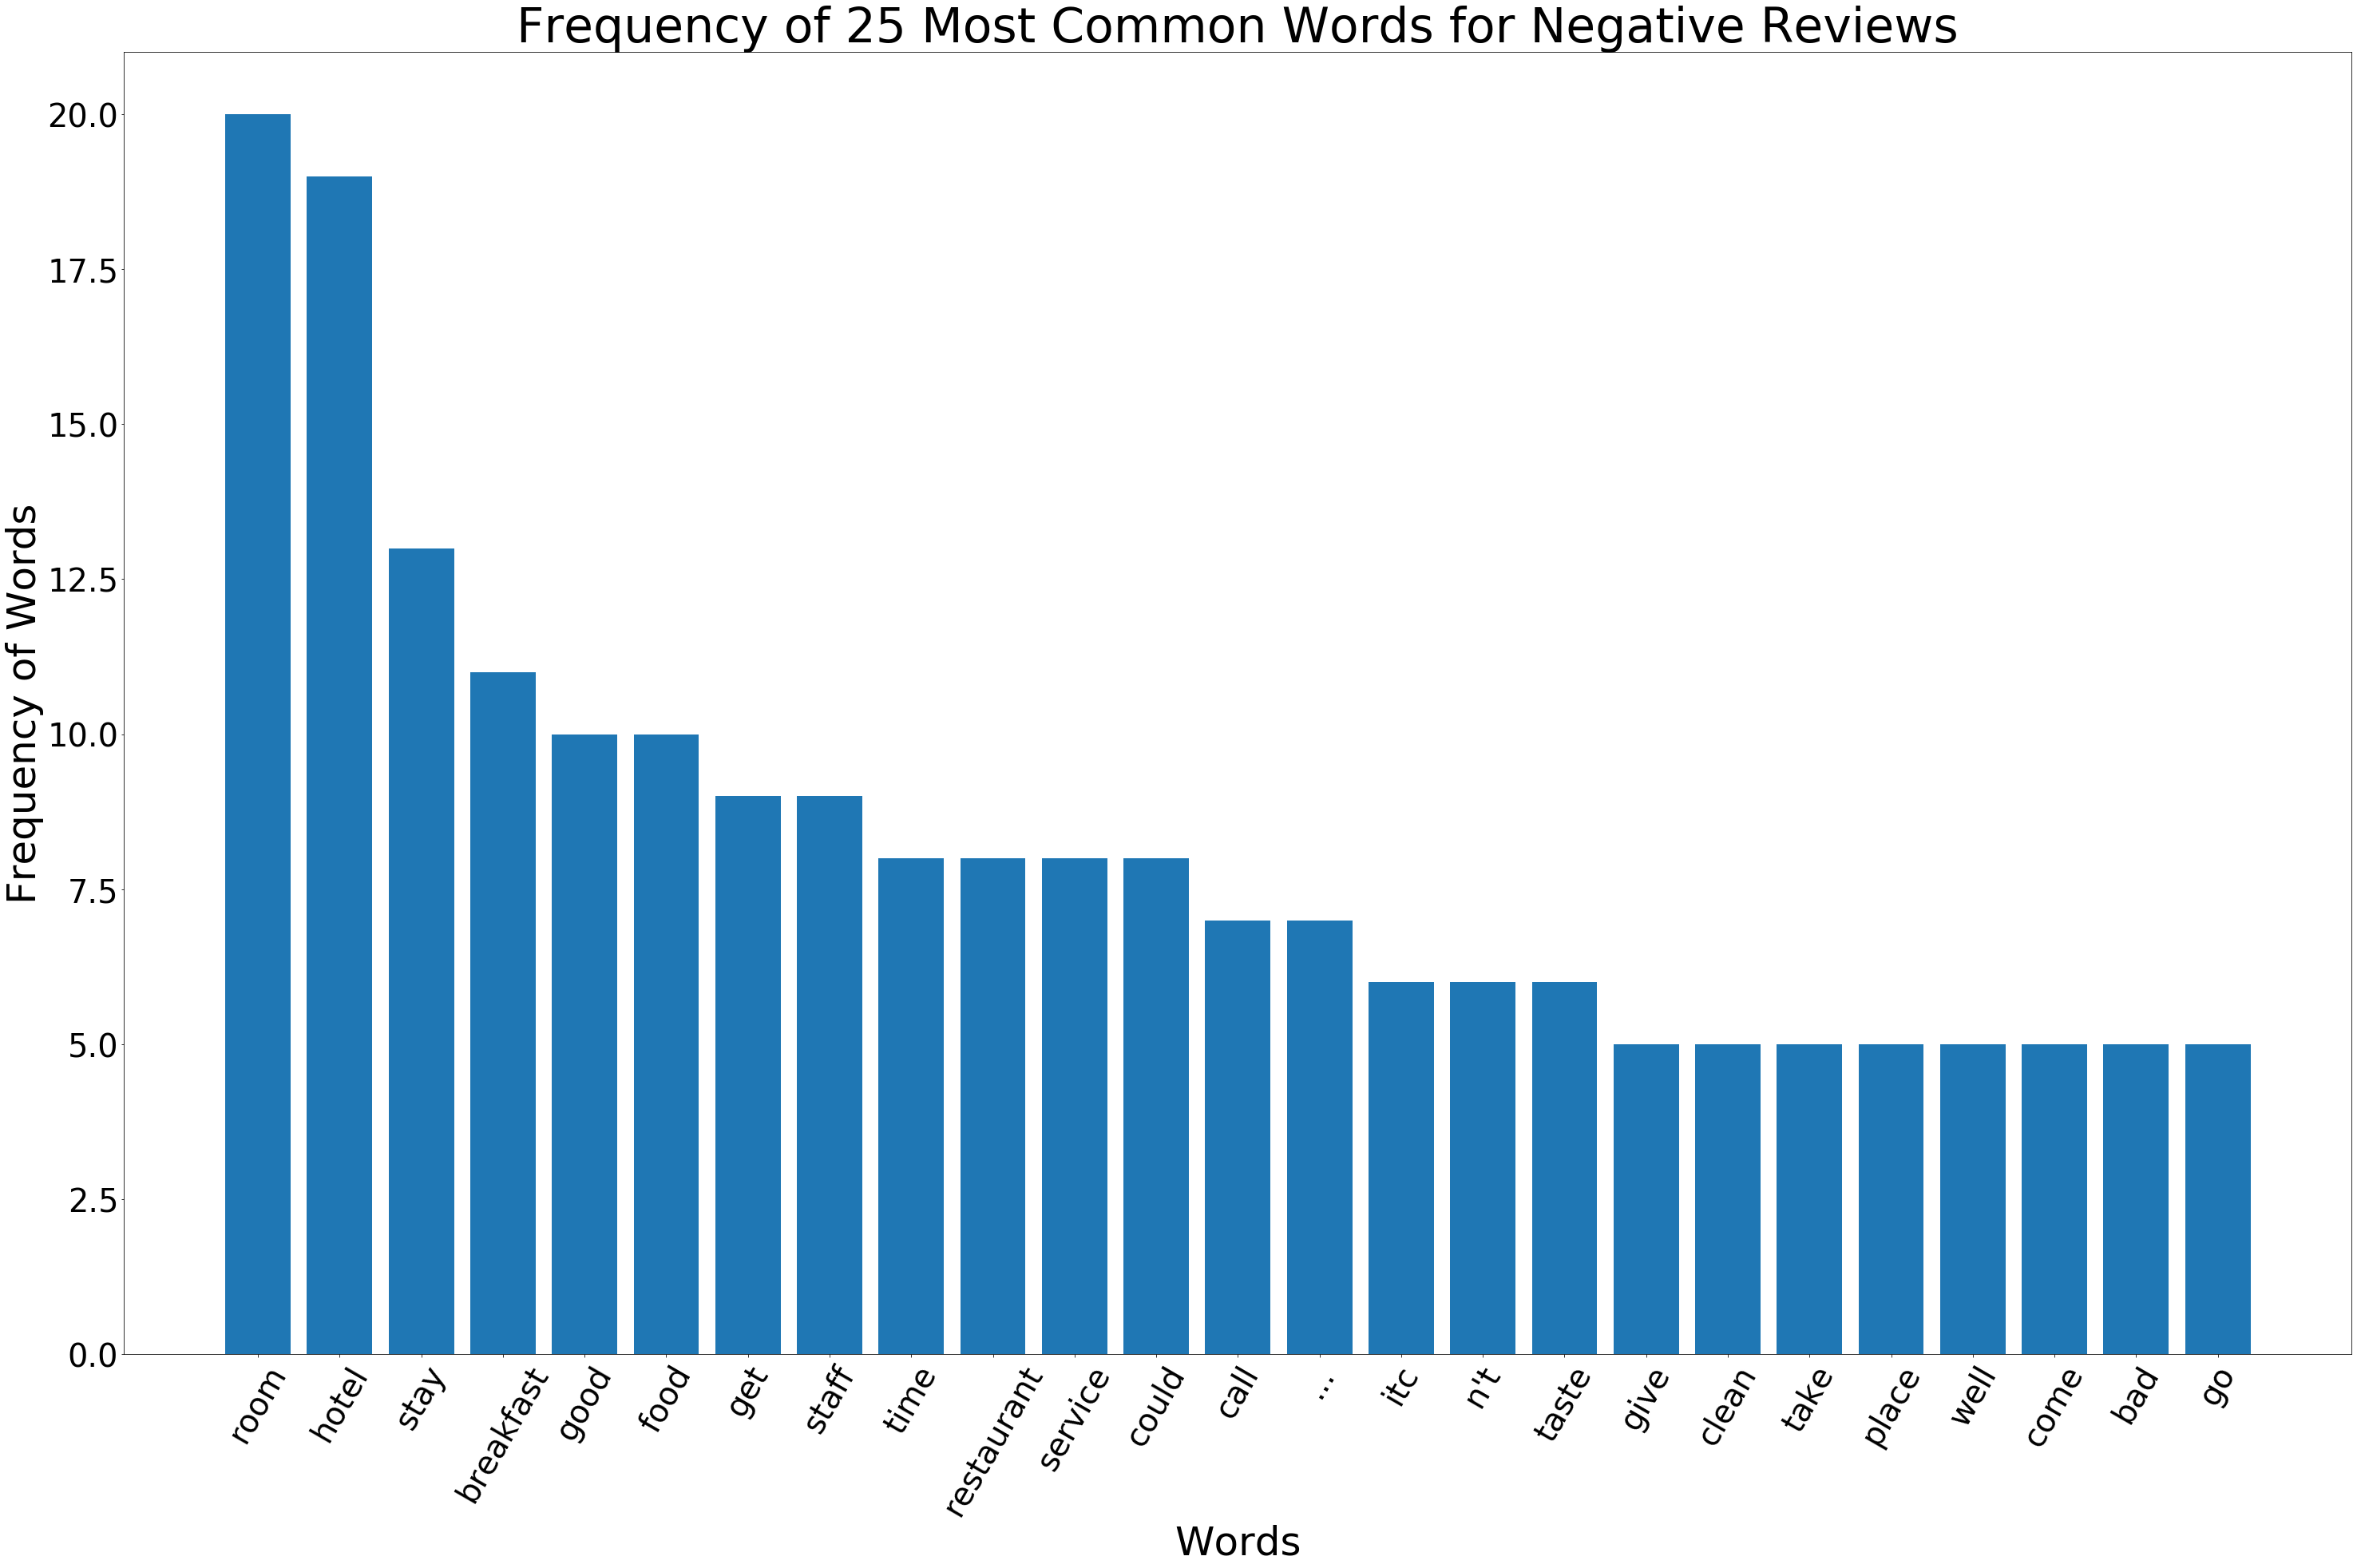

In [24]:
group_by = bb_df_new.groupby('review_type')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_neg = group_by.iloc[0]
words_neg = list(zip(*group_by_neg))[0]
freq_neg = list(zip(*group_by_neg))[1]
plt.figure(figsize=(50,30))
plt.bar(words_neg, freq_neg)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Negative Reviews', fontsize=60)
plt.show()

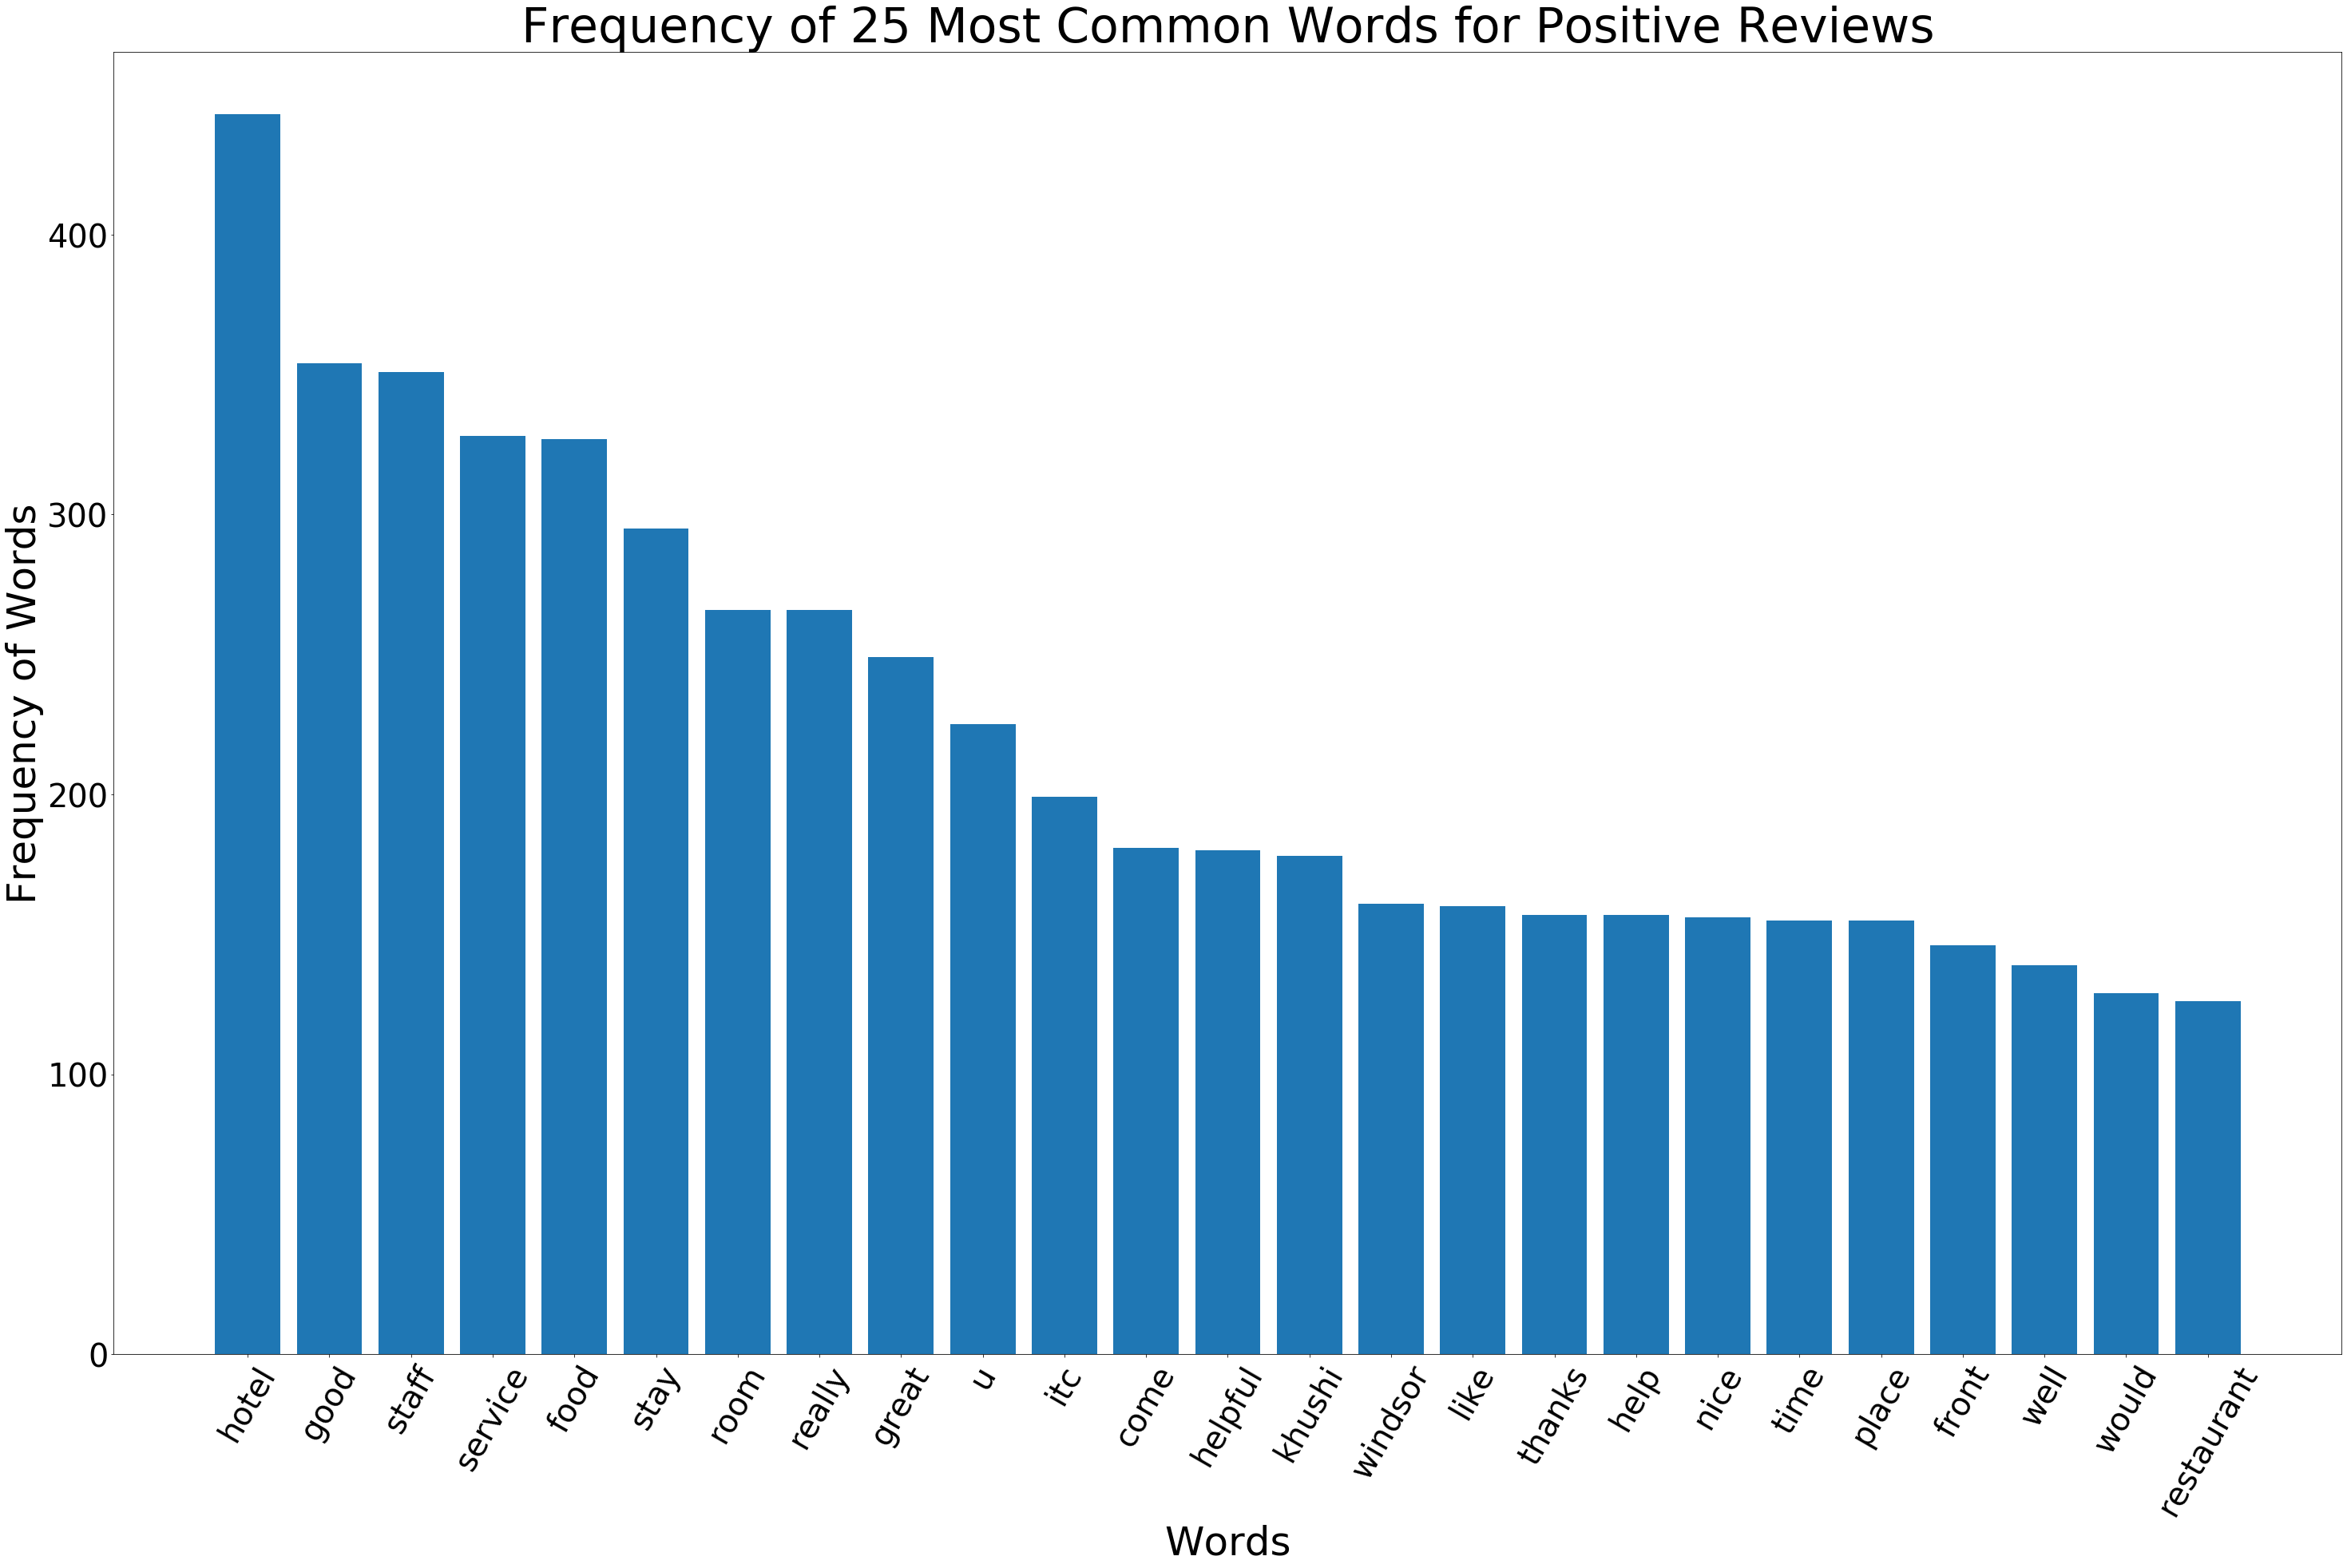

In [25]:
group_by_pos = group_by.iloc[1]
words_pos = list(zip(*group_by_pos))[0]
freq_pos = list(zip(*group_by_pos))[1]
plt.figure(figsize=(50,30))
plt.bar(words_pos, freq_pos)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Positive Reviews', fontsize=60)
plt.show()

****TOPIC MODELLING****

***FOR NEGATIVE REVIEWS***

In [26]:
from gensim import corpora
dictionary_neg = corpora.Dictionary(bb_negative['lemmatized'])
corpus = [dictionary_neg.doc2bow(text) for text in bb_negative['lemmatized']]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary_neg.save('dictionary_neg.gensim')
ldamodel_neg = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary_neg, passes=20)
ldamodel_neg.save('neg_model.gensim')
topics = ldamodel_neg.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.021*"hotel" + 0.021*"bad" + 0.016*"get" + 0.016*"wait" + 0.016*"hr" + 0.011*"experience" + 0.011*"room" + 0.011*"staff"')
(1, '0.029*"room" + 0.018*"hotel" + 0.015*"service" + 0.012*"breakfast" + 0.012*"place" + 0.012*"time" + 0.009*"thé" + 0.009*"give"')
(2, '0.023*"food" + 0.019*"good" + 0.015*"staff" + 0.015*"breakfast" + 0.015*"4" + 0.012*"could" + 0.012*"find" + 0.012*"clean"')
(3, '0.024*"room" + 0.024*"hotel" + 0.024*"..." + 0.019*"stay" + 0.015*"earlier" + 0.010*"could" + 0.010*"month" + 0.010*"call"')
(4, '0.025*"restaurant" + 0.023*"stay" + 0.015*"n\'t" + 0.014*"winsor" + 0.014*"taste" + 0.014*"average" + 0.014*"last" + 0.011*"room"')


In [ ]:
dictionary_neg = gensim.corpora.Dictionary.load('dictionary_neg.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
ldaneg = gensim.models.ldamodel.LdaModel.load('neg_model.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldaneg, corpus, dictionary_neg, sort_topics=False)
pyLDAvis.display(lda_display)

***FOR POSITIVE REVIEWS***

In [27]:
from gensim import corpora
dictionary_pos = corpora.Dictionary(bb_positive['lemmatized'])
corpus_pos = [dictionary_pos.doc2bow(text) for text in bb_positive['lemmatized']]
import pickle
pickle.dump(corpus_pos, open('corpus_pos.pkl', 'wb'))
dictionary_pos.save('dictionary_pos.gensim')
ldamodel_pos = gensim.models.ldamodel.LdaModel(corpus_pos, num_topics=10, id2word = dictionary_pos, passes=20)
ldamodel_pos.save('pos_model.gensim')
topics_pos = ldamodel_pos.print_topics(num_words=8)
for topic in topics_pos:
    print(topic)

(0, '0.032*"stay" + 0.021*"hotel" + 0.019*"..." + 0.016*"itc" + 0.015*"khushi" + 0.014*"thanks" + 0.013*"well" + 0.013*"staff"')
(1, '0.026*"great" + 0.025*"hotel" + 0.023*"staff" + 0.018*"room" + 0.017*"stay" + 0.012*"food" + 0.011*"take" + 0.011*"front"')
(2, '0.037*"hotel" + 0.023*"staff" + 0.018*"place" + 0.018*"food" + 0.015*"helpful" + 0.014*"khushi" + 0.013*"service" + 0.013*"stay"')
(3, '0.031*"hotel" + 0.021*"room" + 0.021*"service" + 0.017*"u" + 0.014*"staff" + 0.013*"full" + 0.011*"great" + 0.011*"stay"')
(4, '0.028*"dublin" + 0.028*"service" + 0.026*"hotel" + 0.024*"good" + 0.024*"best" + 0.023*"khushi" + 0.022*"..." + 0.020*"vishal"')
(5, '0.022*"food" + 0.020*"really" + 0.019*"haba" + 0.019*"come" + 0.018*"service" + 0.018*"back" + 0.018*"u" + 0.016*"nice"')
(6, '0.030*"itc" + 0.025*"windsor" + 0.020*"hotel" + 0.013*"service" + 0.012*"food" + 0.012*"staff" + 0.010*"good" + 0.010*"visit"')
(7, '0.028*"staff" + 0.021*"hotel" + 0.015*"windsor" + 0.015*"great" + 0.015*"really

In [ ]:
dictionary_pos = gensim.corpora.Dictionary.load('dictionary_pos.gensim')
corpus_pos = pickle.load(open('corpus_pos.pkl', 'rb'))
ldapos = gensim.models.ldamodel.LdaModel.load('pos_model.gensim')
import pyLDAvis.gensim
lda_display_pos = pyLDAvis.gensim.prepare(ldapos, corpus, dictionary_pos, sort_topics=False)
pyLDAvis.display(lda_display_pos)